# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Построим модель с максимально большим значением *accuracy*. 

## Откройте и изучите файл

In [138]:
import pandas as pd
from seaborn import heatmap
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


<AxesSubplot:>

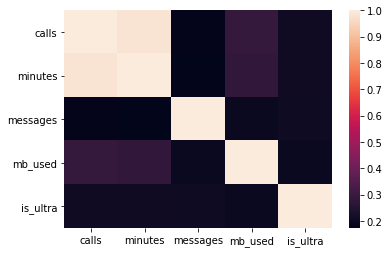

In [6]:
heatmap(df.corr())

*Данные чистые, без пропусков.  
Распределение по тарифам примерно 2:1 (Смарт - 2, Ультра - 1). Значит данные нужно стратифицировать при разделении.    
Корреляция тарифа со всеми критериями одинаково слабая - порядка 20%. Это хорошо*

In [7]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

## Разбейте данные на выборки

In [8]:
train_features, temp_features, train_target, temp_target = train_test_split(features, target, test_size=0.4,
                                                                            random_state=12345, stratify=target)
valid_features, test_features, valid_target, test_target = train_test_split(temp_features, temp_target, test_size=0.5, 
                                                                            random_state=12345, stratify=temp_target)

In [9]:
print(train_features.shape, train_target.shape)
print(valid_features.shape, valid_target.shape)
print(test_features.shape, test_target.shape)

(1928, 4) (1928,)
(643, 4) (643,)
(643, 4) (643,)


## Исследуйте модели

Поскольку имеем дело с задачей не регрессии, а классификации (выбор есть только между двумя тарифами) применим три модели - Дерево решений, Случайный лес и Логистическую регрессию.

### Дерево решений

In [37]:
best_result_dt = 0
best_model_dt = None
res_list_dt = []
res_train_list = []
for i in range(1, 21):
    model_dt = DecisionTreeClassifier(max_depth=i, random_state=12345)
    model_dt.fit(train_features, train_target)
    predictions = model_dt.predict(valid_features)
    predictions_train = model_dt.predict(train_features)
    res = accuracy_score(predictions, valid_target)
    res_list_dt.append(res)
    res_train = accuracy_score(predictions_train, train_target)
    res_train_list.append(res_train)
    if res > best_result_dt:
        best_result_dt = res
        best_model_dt = model_dt
print('Точность модели на валидационной выборке:', best_result_dt)
best_model_dt

Точность модели на валидационной выборке: 0.80248833592535


DecisionTreeClassifier(max_depth=8, random_state=12345)

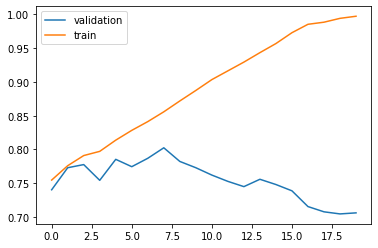

In [38]:
plt.plot(res_list_dt, label='validation')
plt.plot(res_train_list, label='train')
plt.legend();

<function matplotlib.pyplot.show(close=None, block=None)>

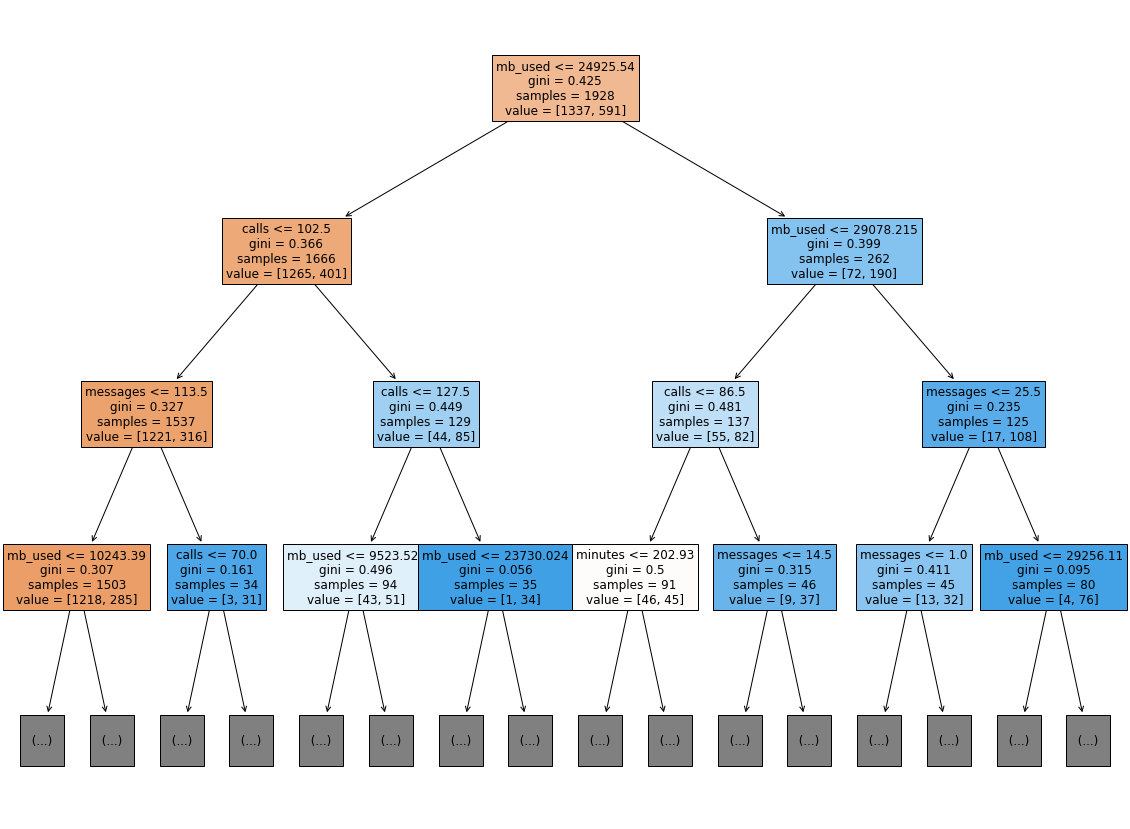

In [12]:
fig, ax = plt.subplots(figsize=(20,15))
tree.plot_tree(best_model_dt, max_depth=3, filled=1, fontsize=12, feature_names=features.columns)
plt.show

### Случайный лес

In [41]:
%%time
best_result_rf = 0
best_model_rf = None
res_list_rf = []
for depth in range(5, 15):
    for est in range(50, 301, 50):
        model_rf = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model_rf.fit(train_features, train_target)
        predictions = model_rf.predict(valid_features)
        res = accuracy_score(predictions, valid_target)
        res_list_rf.append(res)
        if res > best_result_rf:
            best_result_rf = res
            best_model_rf = model_rf
            
print('Точность модели на валидационной выборке:', best_result_rf)
best_model_rf

Точность модели на валидационной выборке: 0.8195956454121306
CPU times: user 35.2 s, sys: 203 ms, total: 35.5 s
Wall time: 35.6 s


RandomForestClassifier(max_depth=9, n_estimators=150, random_state=12345)

<AxesSubplot:>

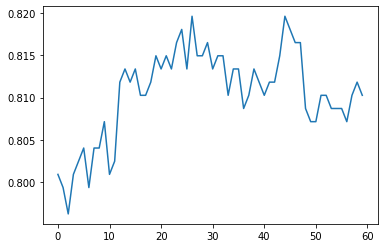

In [42]:
res_list_rf = pd.Series(res_list_rf)
res_list_rf.plot()

### Логистическая регрессия

In [16]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(train_features, train_target)
res = model_lr.score(valid_features, valid_target)
print('Точность модели на валидационной выборке:', res)
model_lr

Точность модели на валидационной выборке: 0.7387247278382582


LogisticRegression(max_iter=1000, random_state=12345)

### Catboost

In [147]:
# Initialize CatBoostClassifier
cb = CatBoostClassifier(verbose=False,
                        random_seed=12345)

param_grid = {'learning_rate': list(np.arange(0.2, 0.41, 0.1)),
            'depth': list(range(2,4,1)),
            'iterations' : list(range(200,601,200))}

cb = GridSearchCV(cb, param_grid,
                  scoring='accuracy',
                  cv=3,
                  refit=True,
                  verbose=False)

cb.fit(train_features, train_target)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f944bd33d30>,
             param_grid={'depth': [2, 3], 'iterations': [200, 400, 600],
                         'learning_rate': [0.2, 0.30000000000000004,
                                           0.4000000000000001]},
             scoring='accuracy', verbose=False)

In [148]:
cb.best_score_

0.7925337002530649

In [149]:
cb.best_params_

{'depth': 2, 'iterations': 200, 'learning_rate': 0.2}

*Лучшие результаты - точность в 82% показала модель Случайного леса.  
Теперь нужно проверить её на тестовой выборке*

## Проверьте модель на тестовой выборке

In [150]:
predictions = best_model_rf.predict(test_features)
res = accuracy_score(predictions, test_target)

print('Точность модели на тестовой выборке:', res)

Точность модели на тестовой выборке: 0.8040435458786936


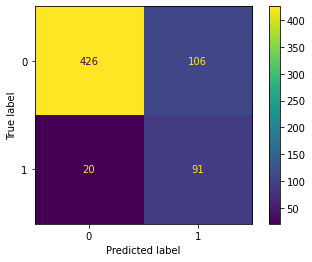

In [151]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(predictions, test_target),
                               display_labels=best_model_rf.classes_).plot();

# plt.show()


Поскольку в нашем случае категории равнозначные, т.е. мы либо угадаем "предрасположенность" клиента к тарифу, либо нет, accuracy (точность) - важный показатель успешности модели. Стоимость любой ошибки для нас - только возможная упущенная прибыль.  
Матрица ошибок показывает, что они распределены примерно одинаково для обоих тарифов, значит модель можно считать успешной.
  

## (бонус) Проверьте модели на адекватность

In [19]:
model_dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dummy.fit(train_features, train_target)
res_dummy = model_dummy.score(test_features, test_target)
print('Accuracy DummyClassifier:', res_dummy)

Accuracy DummyClassifier: 0.6936236391912908


Поскольку точность "подставной" модели ниже нашей, можно считать, что она адекватна и пригодна для работы.

## Общий вывод:

С целью создать эффективную модель для рекомендации тарифа клиентам были проанализированы данные и проверены следующие модели:  
* Дерево решений (78,5% точности на валидационной выборке)
* Случайный лес (82%)
* Логическая регрессия (71%) 
* Catboost (79%)

**Случайный лес с параметрами (max_depth=8, n_estimators=8)** был проверен на тестовой выборке и показал точность **80%**.  

Так же данной моделью был пройден тест на адекватность.  
Модель признана самой эффективной из доступных.